In [1]:
def compute_iou(box, boxes, box_area, boxes_area):

    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou


def compute_overlaps(boxes1, boxes2):

    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])


    overlaps = np.zeros((boxes1.shape[0], boxes2.shape[0]))
    for i in range(overlaps.shape[1]):
        box2 = boxes2[i]
        overlaps[:, i] = compute_iou(box2, boxes1, area2[i], area1)
    return overlaps

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import itertools
import pandas as pd
import time
import cv2
import os
from tqdm import tqdm
import csv


## Requirements: 
#### -To evaluate any model, bounding boxes of ground truths and predictions must be provided in seperate text files. 
#### -The rows must be ordered by image ids
#### -Exact format format of the text files should be like this:
#### -image_id,class_id,bounding_box_coordinates(y1,x1,y2,x2). Example:
####  0,1,[216 400 656 644]
####  1,44,[319 672 837 978]
####  2,1,[435 150 670 250]



###  ---**To obtain quick evaluations** on COCO groundtruths, all that is needed to be changed is "preds.txt" file in vallogs directory.

### 1) Set Directories to where you put your text files in. 

In [16]:
train_dir="/home/katonic/Deep-Performance-Evaluation-Tool/demo/trainlogs/"
val_dir="/home/katonic/Deep-Performance-Evaluation-Tool/demo/vallogs/"
prediction_file="preds.txt"
gtruth_file="gt.txt"

#### Total image numbers to be evaluated:

In [17]:
val_total_image=40136

In [18]:
train_total_image=82080

####  Class Names as in the original dataset. Default one is for COCO

In [19]:
class_names=['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

#### Text reading function

In [20]:
import csv

def text_reader(folder,name):
    print("Reading the file:")
    predictionlist=[]
    with open(os.path.join(folder,name),newline='') as f:
        rows=csv.reader(f)
        for row in rows:
            predictionlist.append(row)
    predictions=[]
    for i in tqdm(range(len(predictionlist))):
        img_id=eval(predictionlist[i][0])
        class_id=eval(predictionlist[i][1])
        bbox=(predictionlist[i][2][1:-1]).split(' ')
        j_list=[]
        for i in bbox:
            k=[]
            if not i=='':
                   j_list.append(i)
        bbox=[eval(i) for i in j_list]
        predictions.append([img_id,class_id,bbox])
    return predictions

### Read GT and Prediction files.

In [58]:
preds[:10]

[[0, 1, [216, 400, 656, 644]],
 [0, 1, [510, 669, 645, 719]],
 [0, 1, [497, 327, 655, 381]],
 [0, 1, [500, 243, 655, 285]],
 [0, 1, [511, 285, 655, 332]],
 [0, 1, [511, 720, 647, 761]],
 [0, 1, [505, 369, 651, 412]],
 [0, 1, [517, 756, 643, 780]],
 [0, 1, [504, 471, 656, 524]],
 [0, 1, [583, 640, 650, 687]]]

In [21]:
preds=text_reader(val_dir,prediction_file)

Reading the file:


100%|██████████| 445043/445043 [00:14<00:00, 31180.85it/s]


In [62]:
gts[:25]

[[0, 5, [409, 303, 421, 320]],
 [0, 14, [662, 245, 906, 778]],
 [0, 37, [534, 393, 659, 575]],
 [0, 1, [216, 404, 650, 646]],
 [0, 1, [504, 365, 656, 410]],
 [0, 1, [498, 329, 656, 376]],
 [0, 1, [506, 245, 656, 279]],
 [0, 1, [510, 277, 654, 331]],
 [0, 1, [509, 668, 648, 714]],
 [0, 1, [504, 718, 648, 764]],
 [0, 1, [515, 621, 651, 662]],
 [0, 1, [504, 471, 650, 521]],
 [0, 1, [506, 514, 634, 545]],
 [0, 1, [523, 757, 646, 781]],
 [0, 1, [589, 571, 657, 620]],
 [0, 8, [540, 573, 595, 625]],
 [0, 8, [478, 593, 581, 764]],
 [0, 25, [531, 667, 575, 714]],
 [0, 27, [587, 282, 631, 315]],
 [0, 61, [667, 248, 715, 751]],
 [0, 1, [496, 409, 653, 437]],
 [0, 14, [748, 242, 772, 326]],
 [0, 1, [498, 603, 664, 770]],
 [1, 46, [169, 1, 843, 706]],
 [1, 52, [475, 341, 627, 520]]]

In [22]:
gts=text_reader(val_dir,gtruth_file)

Reading the file:


100%|██████████| 291871/291871 [00:09<00:00, 31861.25it/s]


In [23]:
def get_container(liste,upto):
    last_n=0
    container=[]
    for index,row in enumerate(liste[:upto]):
        if row[0]==last_n:
            continue
        else:   
            container.append([last_n,index])
            last_n=row[0]
    return container

In [24]:
gt_container=get_container(gts,len(gts))

In [56]:
gt_container[:10]

[[0, 23],
 [1, 28],
 [2, 43],
 [3, 73],
 [4, 75],
 [5, 85],
 [6, 88],
 [7, 90],
 [8, 94],
 [9, 97]]

In [25]:
pred_container=get_container(preds,len(preds))

In [26]:
keyp=0
def load_boxes(im_id,container,datas,val=False):
    global keyp
    if val==True:
        key=keyp
    elif val==False:
        key=0
    if(im_id!=container[im_id-key][0]):
        print("No predictions in image:"+str(im_id))
        keyp+=1
        return [[0,0,0,0]],['BG']
    last=container[im_id-key][1]
    assert im_id>=0
    if im_id>0:
        first=container[im_id-1-key][1]
    else:
        first=0
    class_id_list=[]
    box_list=[]
    
    for data in datas[first:last]:
        class_id=data[1]
        box=data[2]
        class_id_list.append(class_id)
        box_list.append(box)
    return box_list,class_id_list

In [74]:
def evaluate(size,threshold,gt_container,pred_container,preds,gts):
    gtruths = []
    predictions = []    
    for i in tqdm(size):
        preda_bbx,pred_classes=load_boxes(i,pred_container,preds,val=True)
        gta_bbx,gt_classes=load_boxes(i,gt_container,gts)
        overlaps=compute_overlaps(np.array(preda_bbx),np.array(gta_bbx))

        match_count=0
       # discarded_2nd_bb=[]

        try:
            for  j in range(overlaps.shape[1]):
                if overlaps.shape[0]>0:
                    if overlaps[(overlaps[:, j].argmax()),j] > threshold:
                        gtruths.append((gt_classes[j]))
                        predictions.append(pred_classes[overlaps[:,j].argmax()]);
                                                
        except:
            print(overlaps.shape[0],overlaps.shape[1])
    return gtruths,predictions

In [112]:
keyp=0
iou_threshold=0.5
val_total_image = range(1, 1000)
a1, s1 = evaluate(val_total_image,iou_threshold,gt_container,pred_container,preds,gts)

100%|██████████| 999/999 [00:00<00:00, 4868.61it/s]


In [113]:
keyp=0
iou_threshold=0.5
val_total_image = range(1000, 2000)
a2, s2 = evaluate(val_total_image,iou_threshold,gt_container,pred_container,preds,gts)

100%|██████████| 1000/1000 [00:00<00:00, 4752.73it/s]


In [114]:
keyp=0
iou_threshold=0.5
val_total_image = range(2000, 3000)
a3, s3 = evaluate(val_total_image,iou_threshold,gt_container,pred_container,preds,gts)

100%|██████████| 1000/1000 [00:00<00:00, 5122.80it/s]

No predictions in image:2734


In [115]:
cfmatrix1 = confusion_matrix(a1, s1)

In [116]:
cfmatrix2 = confusion_matrix(a2, s2)

In [117]:
cfmatrix3 = confusion_matrix(a3, s3)

#### Normalised Confusion Matrix

In [118]:
def percentage_plot_cfmatrix(confusion_matrix, class_names ,threshold,figsize = (40,40), fontsize=8):
    confusion_matrix=cfmatrix/cfmatrix.sum(axis=1,keepdims=True)
    df_cm = pd.DataFrame(
        (100*confusion_matrix), index=class_names[1:], columns=class_names[1:], 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='.1f',annot_kws={"size": 10})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("ConfusionMatrix@threshold:"+str(threshold)+".png")
    return fig

In [119]:
percentage_plot_cfmatrix(cfmatrix1 ,class_names, iou_threshold)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f2aeb6ab940> (for post_execute):


KeyboardInterrupt: 

In [ ]:
percentage_plot_cfmatrix(cfmatrix2 ,class_names, iou_threshold)

In [ ]:
percentage_plot_cfmatrix(cfmatrix3 ,class_names, iou_threshold)

### Part that calculates Missed instances, false positives etc.:

In [120]:
def elob(size,threshold,gt_container,pred_container,preds,gts,class_names):
    gtruths = []
    predictions = []
    all_gt_classes={i:0 for i in class_names}
    class_matrix={i:[0,0,0,0] for i in class_names}
    miss_matrix={k:[0] for k in class_names}
    for i in tqdm(size):
        preda_bbx,pred_classes=load_boxes(i,pred_container,preds,val=True)
        gta_bbx,gt_classes=load_boxes(i,gt_container,gts)
        overlaps=compute_overlaps(np.array(preda_bbx),np.array(gta_bbx))

        match_count=0
       # discarded_2nd_bb=[]

    
        for  j in range(overlaps.shape[1]):
            all_gt_classes[class_names[gt_classes[j]]]+=1
            if overlaps.shape[0]>0:
                if overlaps[(overlaps[:, j].argmax()),j] > threshold:
                    gtruths.append((gt_classes[j]))
                    predictions.append(pred_classes[overlaps[:,j].argmax()])
                    match_count+=1
                    ### FALSE NEGATIVE

                    # MATCHED BUT WRONG PREDICTION
                    if gt_classes[j]!=pred_classes[overlaps[:,j].argmax()]:       ### 0. EŞLENİP YANLIŞ TAHMİN
                        class_matrix[class_names[gt_classes[j]]][0]+=1
                    else:
                        #TRUE POS
                        class_matrix[class_names[gt_classes[j]]][1]+=1            ### DOĞRULAR
                ##FALSE NEGATIVE
                elif overlaps[(overlaps[:, j].argmax()),j] < threshold:
                    #class_matrix[class_names[gt_classes[j]]][0]+=1
                    class_matrix[class_names[gt_classes[j]]][3]+=1                ### O GT İLE EŞLEŞEN TAHMİN YOK, MİSS
        #FALSE POS
        
        if overlaps.shape[0]>0:
            for k in range(overlaps.shape[0]):
                if overlaps[k,overlaps[k,:].argmax()] < threshold and pred_classes[k]!='BG':    #### PRED İLE EŞLEŞEN GT YOK, FALSE POS
                    class_matrix[class_names[pred_classes[k]]][2]+=1
    return gtruths,predictions,class_matrix,all_gt_classes

###  -Change Intersection of Union Threshold below

In [121]:
keyp=0
iou_threshold=0.5
val_total_image = range(1, 1000)
a1,s1,class_matrix1,all_gts1=elob(val_total_image,iou_threshold,gt_container,pred_container,preds,gts,class_names)

100%|██████████| 999/999 [00:00<00:00, 4076.68it/s]


In [138]:
class_matrix1

{'BG': [0, 0, 0, 0],
 'person': [6, 1817, 1617, 398],
 'bicycle': [1, 45, 35, 9],
 'car': [10, 283, 190, 87],
 'motorcycle': [5, 85, 25, 20],
 'airplane': [1, 44, 17, 14],
 'bus': [7, 48, 13, 4],
 'train': [1, 38, 19, 2],
 'truck': [14, 37, 51, 11],
 'boat': [3, 96, 179, 55],
 'traffic light': [3, 64, 58, 46],
 'fire hydrant': [0, 11, 7, 0],
 'stop sign': [0, 8, 11, 3],
 'parking meter': [1, 10, 2, 7],
 'bench': [7, 41, 65, 29],
 'bird': [1, 66, 66, 12],
 'cat': [2, 36, 8, 0],
 'dog': [6, 38, 8, 6],
 'horse': [2, 35, 13, 4],
 'sheep': [7, 81, 90, 24],
 'cow': [8, 72, 50, 10],
 'elephant': [1, 55, 17, 2],
 'bear': [0, 8, 2, 0],
 'zebra': [0, 67, 30, 2],
 'giraffe': [0, 43, 10, 4],
 'backpack': [13, 32, 72, 21],
 'umbrella': [3, 70, 53, 47],
 'handbag': [18, 45, 93, 52],
 'tie': [1, 42, 30, 23],
 'suitcase': [2, 18, 45, 10],
 'frisbee': [0, 7, 10, 2],
 'skis': [0, 18, 21, 11],
 'snowboard': [3, 17, 16, 2],
 'sports ball': [0, 40, 28, 21],
 'kite': [1, 51, 38, 19],
 'baseball bat': [1, 21

In [122]:
keyp=0
iou_threshold=0.5
val_total_image = range(1000, 2000)
a2,s2,class_matrix2,all_gts2=elob(val_total_image,iou_threshold,gt_container,pred_container,preds,gts,class_names)

100%|██████████| 1000/1000 [00:00<00:00, 4371.59it/s]


In [123]:
keyp=0
iou_threshold=0.5
val_total_image = range(2000, 3000)
a3,s3,class_matrix3,all_gts3=elob(val_total_image,iou_threshold,gt_container,pred_container,preds,gts,class_names)

100%|██████████| 1000/1000 [00:00<00:00, 4557.94it/s]

No predictions in image:2734


In [124]:
pframe1=pd.DataFrame.from_dict(class_matrix1)

In [125]:
pframe2=pd.DataFrame.from_dict(class_matrix2)

In [126]:
pframe3=pd.DataFrame.from_dict(class_matrix3)
#frame=frameg/(frameg.iloc[[0,1,2,3]].sum())

### Order classes by their instance number:

In [127]:
real1=pframe1.reindex((pframe1.iloc[0]+pframe1.iloc[1]+pframe1.iloc[3]).sort_values().index, axis=1)

In [128]:
real2=pframe2.reindex((pframe2.iloc[0]+pframe2.iloc[1]+pframe2.iloc[3]).sort_values().index, axis=1)

In [129]:
real3=pframe3.reindex((pframe3.iloc[0]+pframe3.iloc[1]+pframe3.iloc[3]).sort_values().index, axis=1)

In [130]:
pframe1

,BG,person,bicycle,car,motorcycle,airplane,bus,train,truck,boat,...,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush
0,0,6,1,10,5,1,7,1,14,3,...,1,1,2,2,1,4,0,0,0,0
1,0,1817,45,283,85,44,48,38,37,96,...,0,28,18,108,62,47,7,23,0,8
2,0,1617,35,190,25,17,13,19,51,179,...,2,44,24,376,23,52,9,19,3,7
3,0,398,9,87,20,14,4,2,11,55,...,0,11,5,106,13,5,1,0,1,2


In [131]:
number_of_instances=(pframe1.iloc[[0,1,2,3]].sum())

In [132]:
number_of_instances

BG               0
person        3838
bicycle         90
car            570
motorcycle     135
              ... 
vase           108
scissors        17
teddy bear      42
hair drier       4
toothbrush      17
Length: 81, dtype: int64

In [133]:
percentage1=pframe1/(pframe1.iloc[[0,1,2,3]].sum())

In [134]:
percentage2=pframe2/(pframe2.iloc[[0,1,2,3]].sum())

In [135]:
percentage3=pframe3/(pframe3.iloc[[0,1,2,3]].sum())

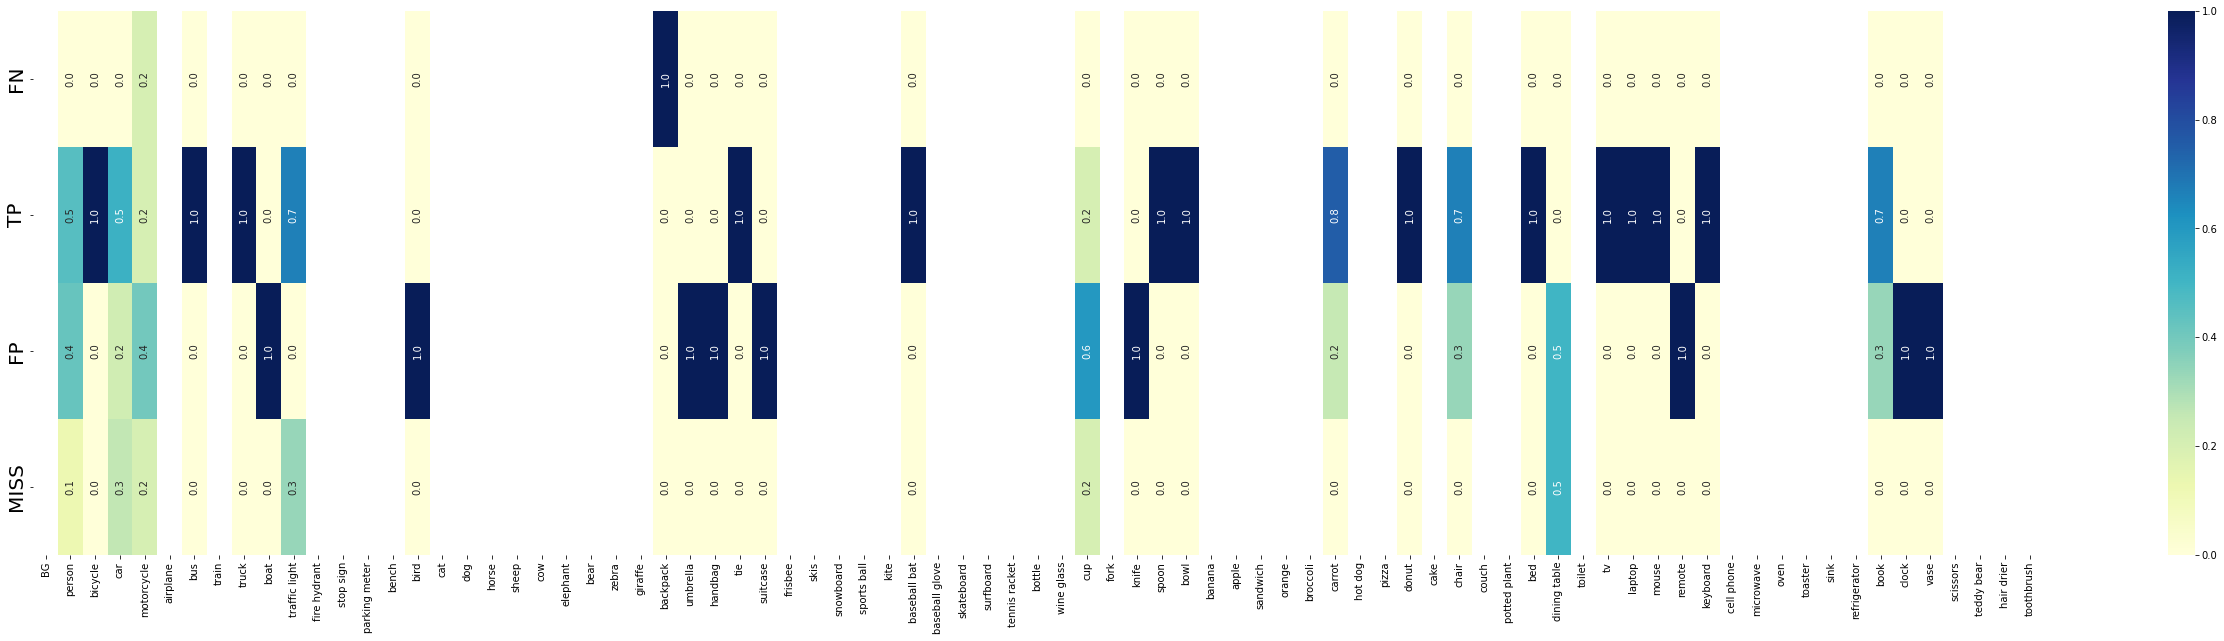

In [100]:
plt.figure(figsize=(45,10))

heatmap=sn.heatmap(percentage1,annot=True,annot_kws={"rotation":90},cmap="YlGnBu",fmt='.1f')
heatmap.yaxis.set_ticklabels(["FN","TP","FP","MISS"], rotation=90, ha='right', fontsize=20),
plt.savefig("CLASS_EVALUATION_TABLE.png")


### False Positives:
####  Detection on Background.
### False Negatives:
#### -Matched locally with GT, but wrong class prediction.
#### - Fails to detect the object. 
### True Positive:
#### Matching the GT with correct class label.



### RECALL:

####  TP/(TP+FN)


### Precision:

### TP/(TP+FP)

In [136]:
def get_recall(class_matrix,class_names):
    recall=[class_matrix[i][1]/(class_matrix[i][1]+class_matrix[i][0]) for i in class_names[1:]]
    return recall

In [110]:
def get_precision(class_matrix,class_names):
    
    precision=[class_matrix[i][1]/(class_matrix[i][1]+class_matrix[i][2]) for i in class_names[1:]]
    return precision

In [44]:
def get_f1_score(precision,recall):
    F1 = [(2 * (precision[k] * recall[k]) / (precision[k] + recall[k])) for k in range(len(class_names[1:]))]
    return F1

In [45]:
def overview(threshold):
    keyp=0
    gt,pred,class_matrix=elob(82080,threshold,gt_container,pred_container,preds,gts,class_names)
    recall=get_recall(class_matrix,class_names)
    precision=get_precision(class_matrix,class_names)
    f1_score=get_f1_score(precision,recall)
    sn.heatmap(f1_score)
    return recall,precision,f1_score

#### How different thresholds affects predictions:
#### Currently  IoU between 0.4-0.8

In [145]:
complete_list=[[],[],[]]
val_total_image = range(1000, 2000)
for i_threshold in range(4,8,1):
    i_threshold=i_threshold/10
    keyp=0
    a,s,class_matrix2,gt_classes=elob(val_total_image,i_threshold,gt_container,pred_container,preds,gts,class_names) ### Train_total_image'ı değiştir.
    recall=get_recall(class_matrix2,class_names)
    precision=get_precision(class_matrix2,class_names)
    f1_score=get_f1_score(precision,recall)
    complete_list[0].append(recall)
    complete_list[1].append(precision)
    complete_list[2].append(f1_score)

100%|██████████| 1000/1000 [00:00<00:00, 3906.71it/s]


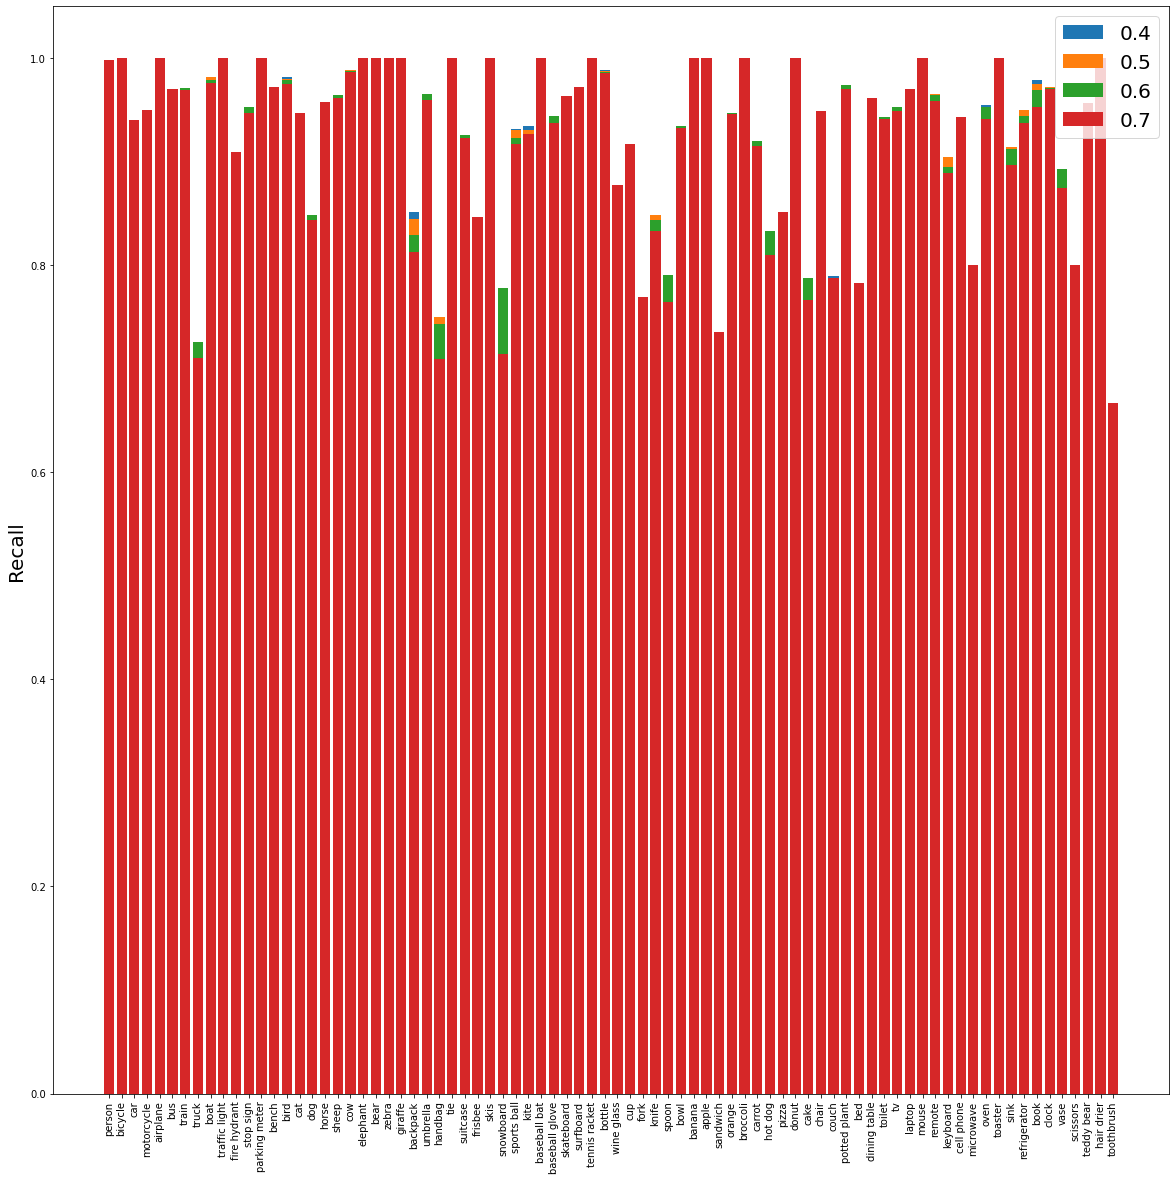

In [146]:
plt.figure(figsize=(20,20))
plt.xticks([i for i in range(80)],class_names[1:],rotation='vertical')
for i in range(len(complete_list[0])):
    plt.bar(class_names[1:],complete_list[0][i])
plt.ylabel("Recall",fontsize=20)
plt.legend(('0.4', '0.5',"0.6","0.7"),fontsize=20)
plt.savefig("0.4-0.7 Recall.png")

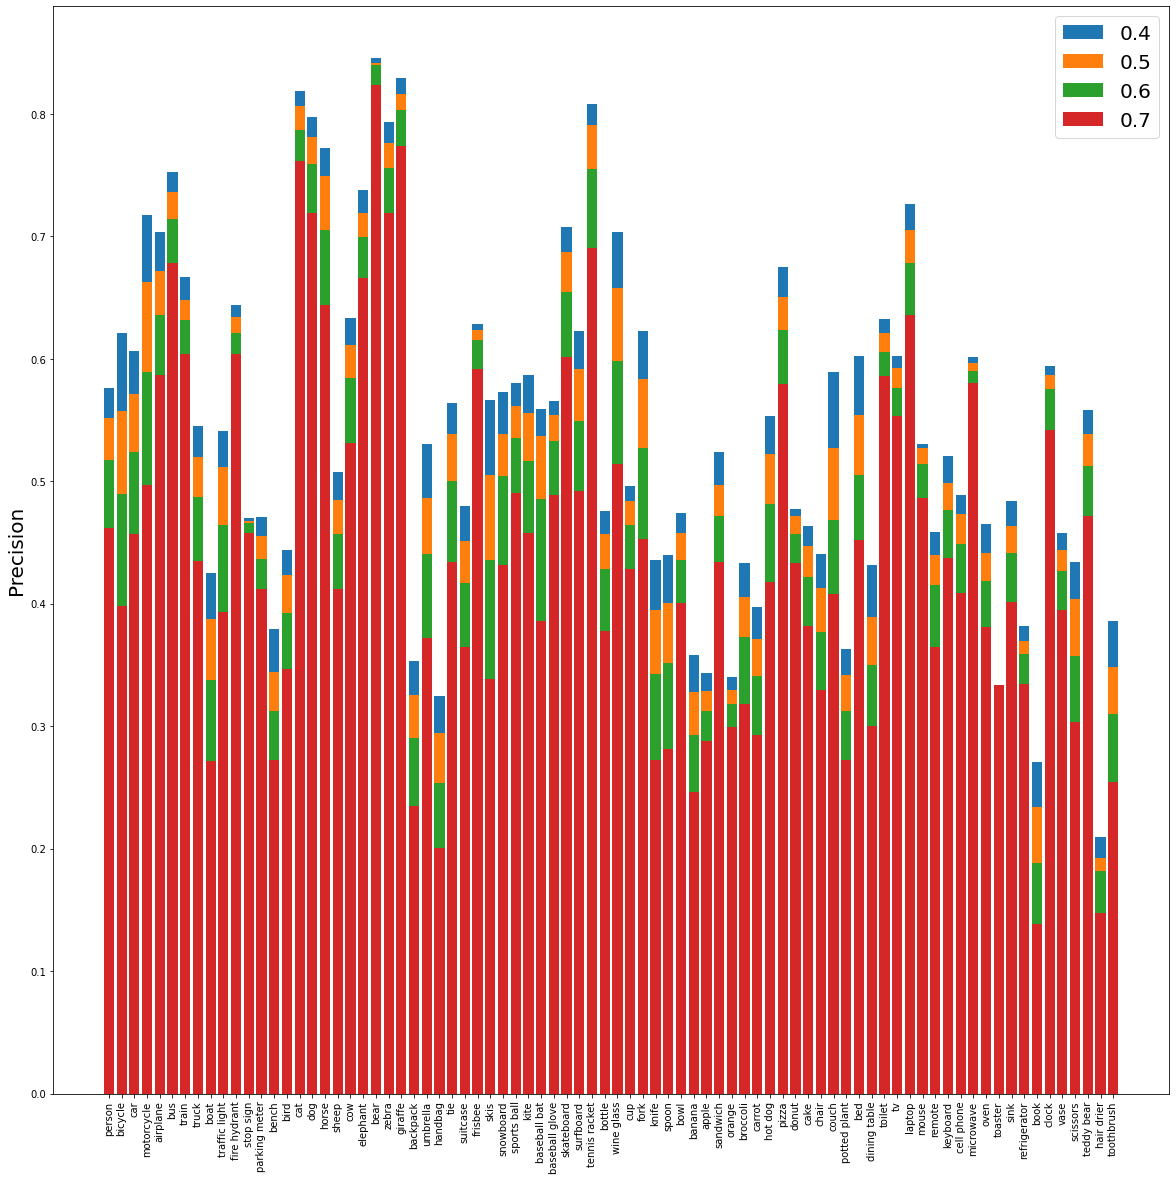

In [48]:
plt.figure(figsize=(20,20))
plt.xticks([i for i in range(80)],class_names[1:],rotation='vertical')
for i in range(len(complete_list[1])):
    plt.bar(class_names[1:],complete_list[1][i])
plt.ylabel("Precision",fontsize=20)
plt.legend(('0.4', '0.5',"0.6","0.7"),fontsize=20)
plt.savefig("0.4-0.7 Precision.png")

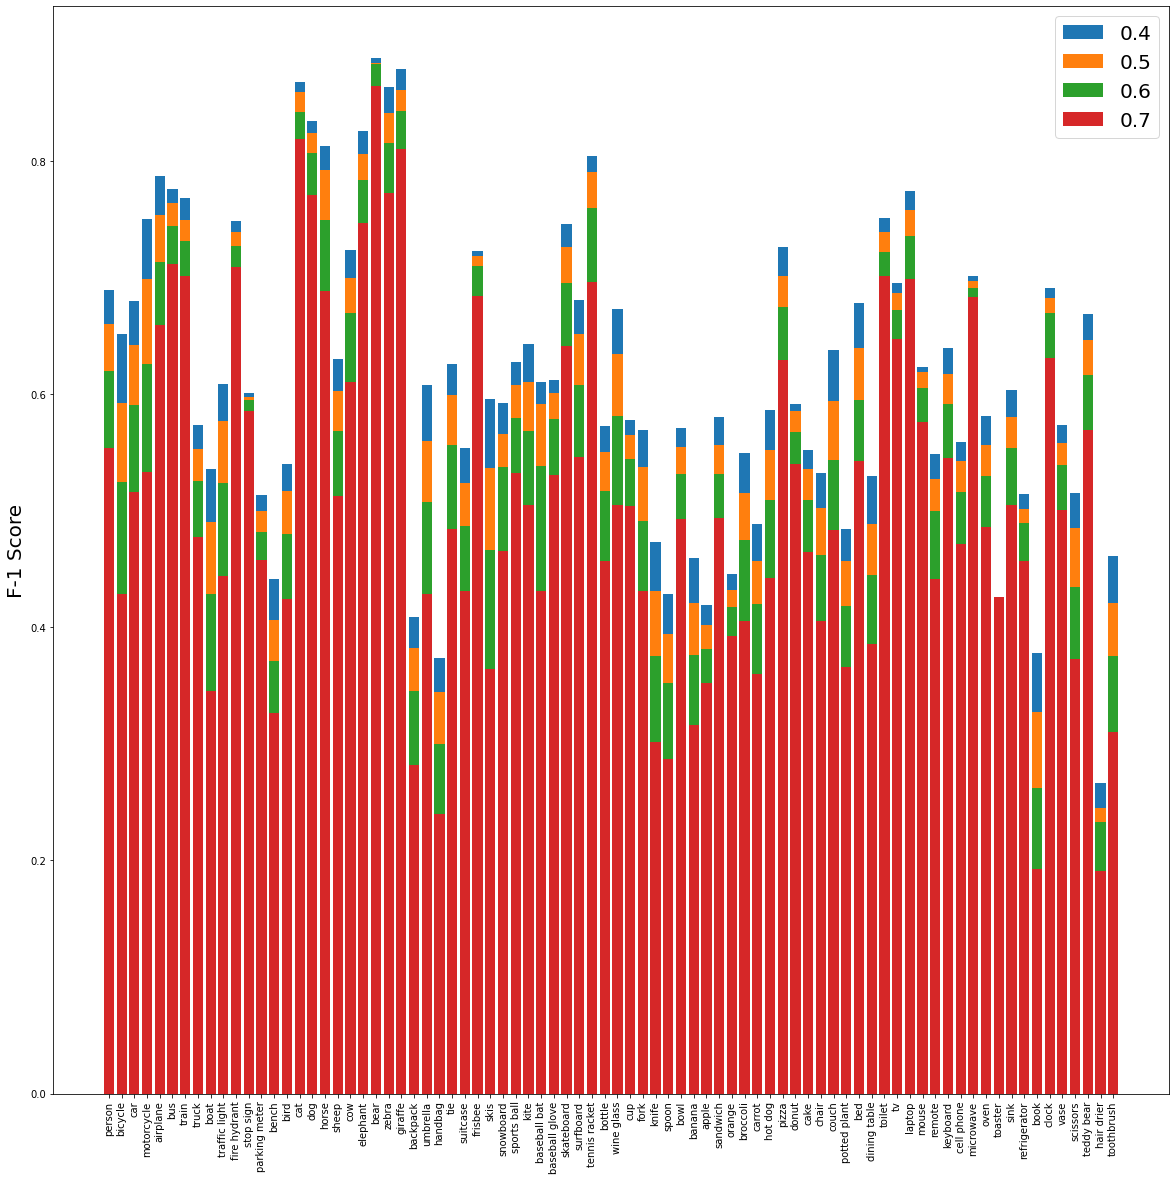

In [49]:
plt.figure(figsize=(20,20))
plt.xticks([i for i in range(80)],class_names[1:],rotation='vertical')
for i in range(len(complete_list[2])):
    plt.bar(class_names[1:],complete_list[2][i])
plt.ylabel("F-1 Score",fontsize=20)
plt.legend(('0.4', '0.5',"0.6","0.7"),fontsize=20)
plt.savefig("0.4-0.7 F-1 Score.png")

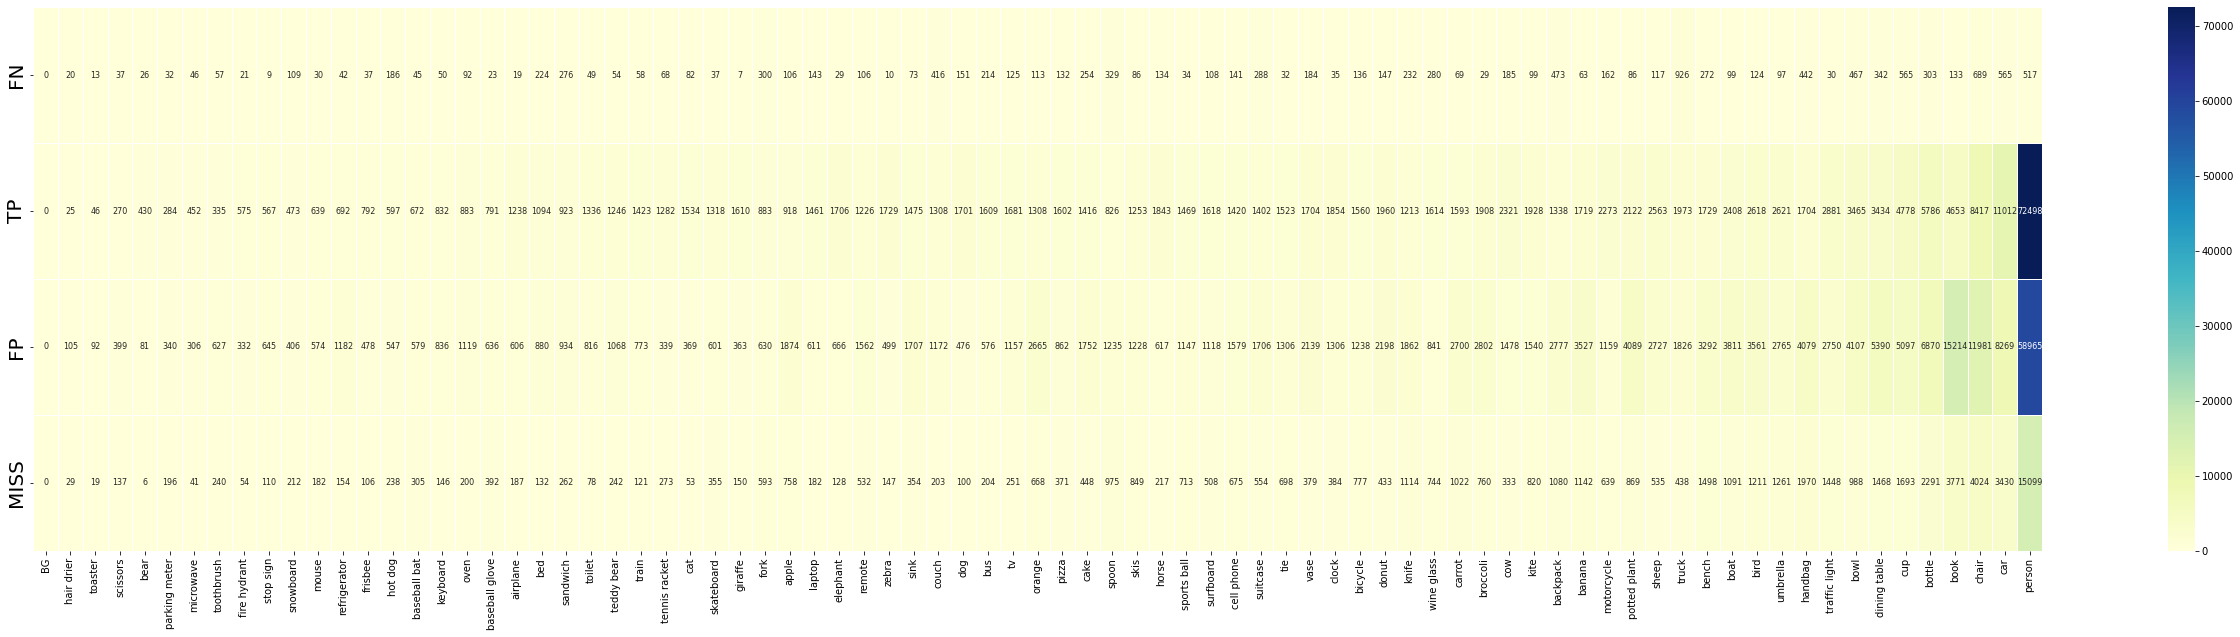

In [50]:
plt.figure(figsize=(45,10))

heatmap=sn.heatmap(real,annot=True,cmap="YlGnBu",fmt='d',annot_kws={'size':8},linewidths=.5)

heatmap.yaxis.set_ticklabels(["FN","TP","FP","MISS"], rotation=90, ha='right', fontsize=20),
plt.savefig("TopPerforming.png")

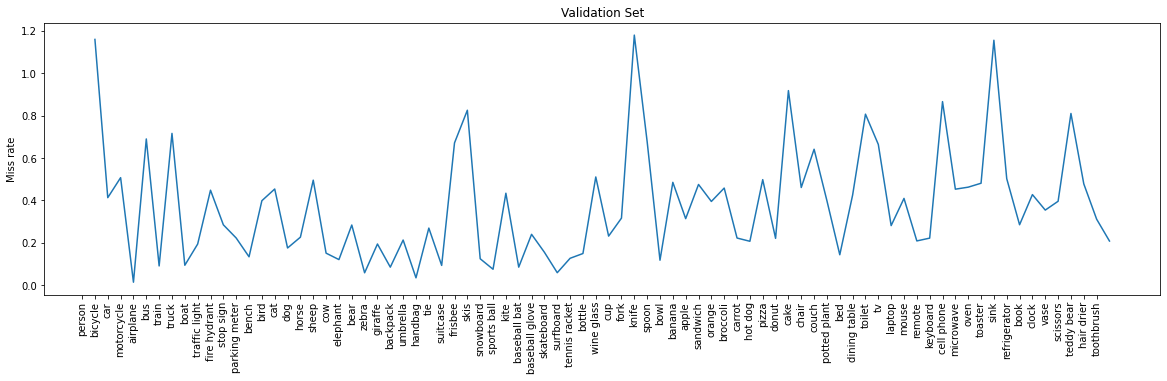

In [51]:
plt.figure(figsize=(20,5))
plt.plot((real.iloc[3]/(real.iloc[1])))
plt.xticks([i for i in range(80)],class_names[1:],rotation='vertical');

plt.title("Validation Set")
plt.ylabel("Miss rate")
plt.savefig("Val-Comparison.png")


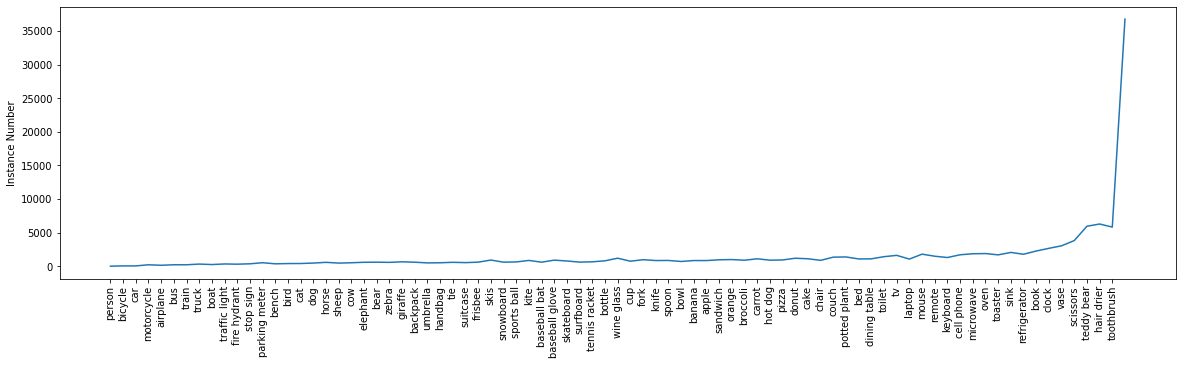

In [52]:
plt.figure(figsize=(20,5))
plt.plot(real.mean());
plt.ylabel("Instance Number")
plt.xticks([i for i in range(80)],(class_names[1:]),rotation='vertical');
